# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

**Импортирую библиотеки:**

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import math
import matplotlib.pyplot as plt
from scipy import stats as st
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from IPython.core.display import HTML
from datetime import datetime, timedelta
from sklearn.pipeline import Pipeline
import seaborn as sns
import time
import lightgbm as lgbm
from lightgbm import LGBMRegressor
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.compose import ColumnTransformer
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

**Загружаю данные:**

In [2]:
df = pd.read_csv('/datasets/autos.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


**Признаки:**
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Проверю количество пропусков:**

In [4]:
print('Количество пропусков:')
print(df.isna().sum())

Количество пропусков:
DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64


**Удаляю дубликаты:**

In [5]:
df = df.drop_duplicates().reset_index(drop=True)
print(df.shape)

(354365, 16)


***Признаки, которые не требуют обработки***:  
- *'price'*: целевой признак. Имеются нулевые значения, владельцы отдают даром автомобили - оставляем без изменений;
- *'kilometer'*: пропущенных данных нет, значения адекватны;
- *'brand'*: пропущенных данных нет, значения адекватны;

***Признаки, которые можно удалить, так как они не имеют предсказательной силы***:  
- *'date_crawled'*: пропущенных данных нет. Признак не имеет предсказательной силы, исключаем.
- *'registration_month'*: 
- *'date_created'*: пропущенных данных нет. Признак не имеет предсказательной силы, исключаем.
- *'number_of_pictures'*: имеется только единственное значение. Пропущенных данных нет. Исключаем.
- *'postal_code'*: пропущенных данных нет. Признак имеет очень слабую предсказательную силу, можно исключить.
- *'last_seen'*: пропущенных данных нет. Признак не имеет предсказательной силы, можно исключить.

**Удаляю признаки, которые не имеют предсказательной силы::**

In [6]:
df = df.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 
                              'PostalCode', 'LastSeen'], axis=1)

In [7]:
df['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [8]:
RY = df['RegistrationYear'].unique().tolist()

In [9]:
np.sort(RY)

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

**Построю график распределения значения для поля "RegistrationYear"**

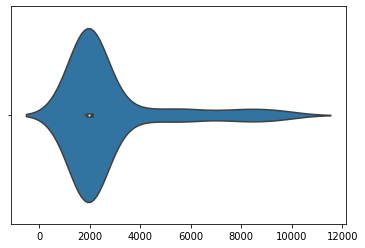

In [10]:
ax = sns.violinplot(RY)

Имеются аномальные значения, например год регистрации 1111 или 5000. Поскольку это явная ошибка, возможно вызванная некорректным форматом введимых данных в соответствующее поле, либо техническим сбоем, исключим позиции, год регистрации для которых выходит за рамки интервала 1900-2021 гг;

**Избавляюсь от аномальных значений:**

In [11]:
df = df.query('(RegistrationYear >= 1900) and (RegistrationYear <= 2021)').reset_index(drop=True)
df = df.query('Power <= 3500').reset_index(drop=True)

**Заполняю пропуски:**

Так как нет уточняющей информации по полям 'VehicleType', 'Gearbox', 'FuelType', 'Model', 'NotRepaired', заменю пропуски в этих полях на значения "неизвестно", "другие" и т.д.

In [12]:
df.loc[:, ['VehicleType', 'Gearbox', 'FuelType']] = df.loc[:,['VehicleType', 'Gearbox', 'FuelType']].fillna('unknown')
df['Model'] = df['Model'].fillna('other')
df['NotRepaired'] = df['NotRepaired'].fillna('no')

In [13]:
df

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,no
1,18300,coupe,2011,manual,190,other,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
354101,0,unknown,2005,manual,0,colt,150000,petrol,mitsubishi,yes
354102,2200,unknown,2005,unknown,0,other,20000,unknown,sonstige_autos,no
354103,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354104,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


**Проверю типы данных:**

In [14]:
print(df.dtypes)

Price                int64
VehicleType         object
RegistrationYear     int64
Gearbox             object
Power                int64
Model               object
Kilometer            int64
FuelType            object
Brand               object
NotRepaired         object
dtype: object


Так как для построения моделей признаки не могут быть категориальными, применю технику OHE для 'VehicleType', 'Gearbox', 'FuelType', 'NotRepaired' и OrdinalEcoder для 'Model', 'Brand'.

**Выделим числовые признаки, признаки для OHE и для OrdinalEcoder:**

In [15]:
numeric_columns = ['Price', 'RegistrationYear', 'Power', 'Kilometer']
ohe_columns = ['VehicleType', 'Gearbox', 'FuelType', 'NotRepaired']
ordinal_columns = ['Model', 'Brand']

***Порядковое кодирование:***

In [16]:
encoder = OrdinalEncoder()
df_ordinal = pd.DataFrame(encoder.fit_transform(df.loc[:, ordinal_columns]),
                            columns=ordinal_columns)

display(df_ordinal.head())
print(df_ordinal.shape)

,Model,Brand
0,116.0,38.0
1,166.0,1.0
2,117.0,14.0
3,116.0,38.0
4,101.0,31.0


(354106, 2)


***OHE:***

In [17]:
df_ohe = pd.get_dummies(df.loc[:, ohe_columns], drop_first=True)
display(df_ohe.head())
print(df_ohe.shape)

,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_unknown,VehicleType_wagon,Gearbox_manual,Gearbox_unknown,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,FuelType_unknown,NotRepaired_yes
0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0
1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1
2,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0


(354106, 18)


***Объединю полученные датафреймы в единый для дальнейшей работы:***

In [18]:
df_final = df[numeric_columns].join([df_ordinal, df_ohe])
display(df_final.head())
print(df_final.shape)

,Price,RegistrationYear,Power,Kilometer,Model,Brand,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,...,Gearbox_manual,Gearbox_unknown,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,FuelType_unknown,NotRepaired_yes
0,480,1993,0,150000,116.0,38.0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
1,18300,2011,190,125000,166.0,1.0,0,1,0,0,...,1,0,0,1,0,0,0,0,0,1
2,9800,2004,163,125000,117.0,14.0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1500,2001,75,150000,116.0,38.0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,3600,2008,69,90000,101.0,31.0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0


(354106, 24)


**Разобью данные на выборки:**

In [19]:
df_train, df_valid = train_test_split(df_final, test_size=0.25, random_state=12345) 
features_train = df_train.drop(['Price'], axis=1)
target_train = df_train['Price']
features_valid = df_valid.drop(['Price'], axis=1)
target_valid = df_valid['Price'] 
df_train, df_test = train_test_split(df_train, test_size=0.25, random_state=12345) 
features_train = df_train.drop(['Price'], axis=1)
target_train = df_train['Price']
features_test = df_test.drop(['Price'], axis=1)
target_test = df_test['Price'] 

In [20]:
features_numeric_columns = numeric_columns[1:4]
print(features_numeric_columns)

['RegistrationYear', 'Power', 'Kilometer']


**Масштабирую признаки:**

In [21]:
scaler=StandardScaler()
scaler.fit(features_train[features_numeric_columns])

features_train.loc[:, features_numeric_columns] = scaler.transform(features_train.loc[:, features_numeric_columns])
features_valid.loc[:, features_numeric_columns] = scaler.transform(features_valid.loc[:, features_numeric_columns])
features_test.loc[:, features_numeric_columns] = scaler.transform(features_test.loc[:, features_numeric_columns])

**Вывод**  

Подготовила данные для обучения модели: провела кодирование, масштабирование, разделение выборок.

## Обучение моделей

*Проверяю четыре модели: линейная регрессия, дерево решений, случайный лес и модель градиентного бустинга*

**Модель "Линейная регрессия"**

In [22]:
%%time
LR_model = LinearRegression()
LR_model.fit(features_train, target_train)
predictions_valid = LR_model.predict(features_valid)
LR_result = (mean_squared_error(target_valid, predictions_valid))** 0.5
print('RMSE модели случайного леса на валидационной выборке:', LR_result)

RMSE модели случайного леса на валидационной выборке: 3137.910494803874
CPU times: user 310 ms, sys: 180 ms, total: 490 ms
Wall time: 427 ms


**Модель "Дерево решений"**

In [23]:
%%time
DR_model = DecisionTreeRegressor(random_state=12345)
DR_parameters = {'max_depth': range(1,10)}
DR_grid = GridSearchCV(DR_model, DR_parameters, cv=3)
DR_grid.fit(features_train, target_train)
DR_best_parameters = DR_grid.best_params_
print('Оптимальные параметры модели:', DR_best_parameters)

Оптимальные параметры модели: {'max_depth': 9}
CPU times: user 7.85 s, sys: 22.4 ms, total: 7.88 s
Wall time: 8.36 s


In [24]:
%%time
DR_model = DecisionTreeRegressor(random_state=12345, max_depth=9) 
DR_model.fit(features_train, target_train) 
DR_predictions_valid= DR_model.predict(features_valid) 
DR_result = (mean_squared_error(target_valid, DR_predictions_valid))** 0.5 
print("RMSE модели дерево решений на валидационной выборке:", DR_result)

RMSE модели дерево решений на валидационной выборке: 2178.9023190191065
CPU times: user 598 ms, sys: 19.9 ms, total: 617 ms
Wall time: 627 ms


**Модель "Случайный лес"**

In [25]:
%%time
SL_model = RandomForestRegressor(random_state=12345)
SL_parameters = {'n_estimators': range(1,5), 'max_depth': range(2,8)}
SL_grid = GridSearchCV(SL_model, SL_parameters, cv=3)
SL_grid.fit(features_train, target_train)
SL_best_parameters = SL_grid.best_params_
print('Оптимальные параметры модели:', SL_best_parameters)

Оптимальные параметры модели: {'max_depth': 7, 'n_estimators': 4}
CPU times: user 29.9 s, sys: 42.2 ms, total: 29.9 s
Wall time: 30.9 s


In [26]:
%%time
SL_model = RandomForestRegressor(random_state=12345, max_depth=7, n_estimators=4) 
SL_model.fit(features_train, target_train) 
SL_predictions_valid = SL_model.predict(features_valid) 
SL_result = (mean_squared_error(target_valid, SL_predictions_valid))** 0.5 
print("RMSE модели случайный лес на валидационной выборке:", SL_result)

RMSE модели случайный лес на валидационной выборке: 2284.768494492866
CPU times: user 1.28 s, sys: 28 ms, total: 1.31 s
Wall time: 1.32 s


**Модель градиентного бустинга**

In [27]:
%%time
model = LGBMRegressor(boosting_type='gbdt', device='cpu', verbose=0, seed=42)
model.fit(features_train, target_train, verbose=10)
probabilities_valid = model.predict(features_valid)
LGBMR_result = mean_squared_error(target_valid, probabilities_valid)**0.5
print("RMSE модели LGBMRegressor на валидационной выборке:",LGBMR_result)

RMSE модели LGBMRegressor на валидационной выборке: 1859.5150410948831
CPU times: user 8.58 s, sys: 90.1 ms, total: 8.67 s
Wall time: 8.78 s


**Тестирование лучших моделей: "Дерево решений" и модели градиентного бустинга**

In [28]:
DR_model = DecisionTreeRegressor(random_state=12345, max_depth=9)
DR_model.fit(features_train, target_train) 
DR_predictions_test = DR_model.predict(features_test) 
DR_result_test = (mean_squared_error(target_test, DR_predictions_test))** 0.5  
 
print("RMSE модели дерево решений на тестовой выборке:", DR_result_test)

RMSE модели дерево решений на тестовой выборке: 2179.3966246503755


In [29]:
model.fit(features_train, target_train, verbose=10) 
probabilities_test = model.predict(features_test)
LGBMR_result_test = (mean_squared_error(target_test, probabilities_test))**0.5
 
print("RMSE модели градиентного бустинга на тестовой выборке:", LGBMR_result_test)

RMSE модели градиентного бустинга на тестовой выборке: 1853.011337471725


## Анализ моделей

**Вывод:** была проанализирована работа четырех моделей: модель линейной регрессии, модель "Дерево решений"(ДР) и модель "Случайный лес"(СЛ). Наименьшее время обучения кода у модели линейной регрессии: 117мс, у ДР: 154мс и у СЛ: 2с. Точность у моделей ДР и СЛ соотвественно: RMSE=2097 и 2285. Следовательно, наиболее удачная модель по точности из ранее известных - модель "Дерево решений".
Наилучшую точность показала модель градиентного бустинга: RMSE = 1853.

Скорость работы модели градиентного бустинга - 10.4с.